In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# !pip install tensorflow-datasets

In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
data = tfds.load('fashion_mnist', split='train')

2024-05-26 22:25:15.265870: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-26 22:25:15.265949: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-26 22:25:15.265960: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-26 22:25:15.266995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-26 22:25:15.267327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
data.as_numpy_iterator().next()

2024-05-26 22:25:15.482966: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

In [6]:
data.as_numpy_iterator().next()['label']

2024-05-26 22:25:15.517618: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2

In [7]:
import numpy as np

In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

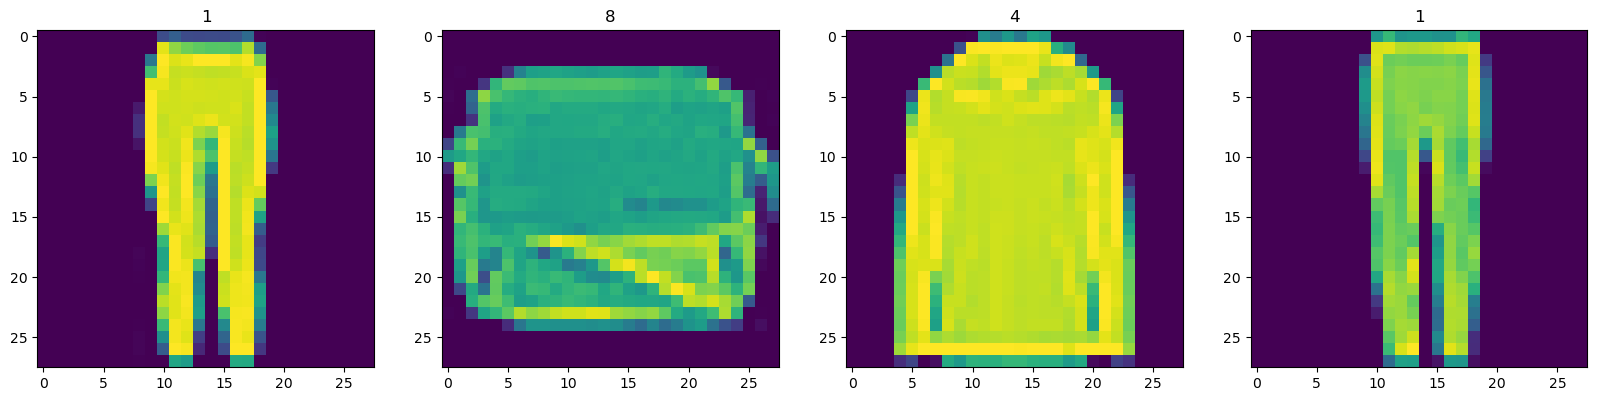

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 15))
for idx in range(4):
    sample = data_iterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [11]:
def scale_images(data):
    image = data['image']
    return image / 255

In [12]:
# data = tfds.load('fashion_mnist', split='train')
data = data.map(scale_images)
data = data.cache()
data = data.shuffle(60000)
data = data.batch(128)
data = data.prefetch(64)

In [13]:
data.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, LeakyReLU, Reshape, Dropout, UpSampling2D, Conv2DTranspose

#### Building Generator

In [15]:
def build_generator():
    model = Sequential()
    
    # takes in random values and reshapes the image to 7 * 7 * 128 
    # Beginning of a generated image - Target size (28 * 28 * 128)
    model.add(Dense(7 * 7 * 128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))
    
    # Upsampling layer block 1
    # size becomes (14 * 14 * 128) in this layer
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
        
    # Upsampling layer block 2
    # size becomes (28 * 28 * 128) in this layer 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
        
    # Downsampling layer block 1
    # Not exactly downsampling- but reducing the channels to make ready for '1' output
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Downsampling layer block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional Layer to reduce to 1 channel (output)
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [16]:
# test_model = build_generator()
# test_model.summary()

generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [17]:
img = generator.predict(np.random.randn(4, 128, 1))
img.shape

1/1 [==============================] - 0s 212ms/step


2024-05-26 22:25:18.509956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(4, 28, 28, 1)

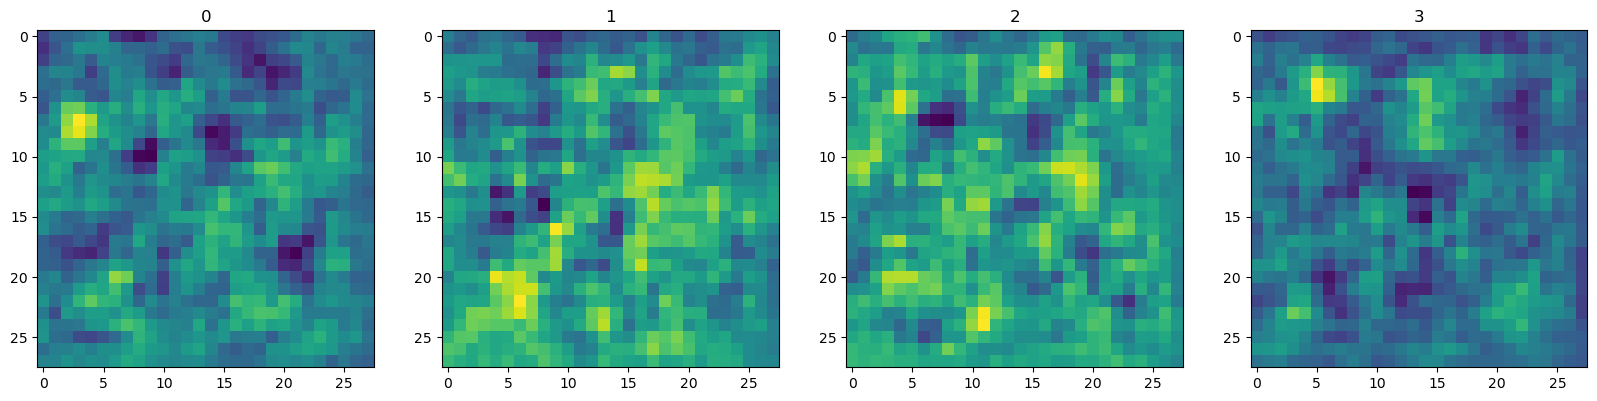

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 15))
for idx, im in enumerate(img):
    ax[idx].imshow(np.squeeze(im))
    ax[idx].title.set_text(idx)

#### Building Discriminator

In [19]:
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [20]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [21]:
disc_img = img[0]
disc_img.shape

(28, 28, 1)

In [22]:
discriminator.predict(img)

1/1 [==============================] - 0s 96ms/step


2024-05-26 22:25:19.377738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.5007264 ],
       [0.50064456],
       [0.5006909 ],
       [0.5006224 ]], dtype=float32)

In [23]:
discriminator.predict(np.expand_dims(disc_img, 0))

1/1 [==============================] - 0s 56ms/step


array([[0.5007264]], dtype=float32)

In [24]:
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [25]:
# M1/M2 Macbooks

from tensorflow.keras.optimizers.legacy import Adam

In [26]:
gen_opt = Adam(learning_rate=0.0001)
disc_opt = Adam(learning_rate=0.00001)

gen_loss = BinaryCrossentropy()
disc_loss = BinaryCrossentropy()

In [27]:
from tensorflow.keras.models import Model

In [29]:
class FasionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, gen_opt, disc_opt, gen_loss, disc_loss, *args, **kwargs): # g_opt, d_opt, g_loss, d_loss
        super().compile(*args, **kwargs)
        
        self.gen_opt = gen_opt
        self.disc_opt = disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        
    
    def train_step(self, batch):
        # Getting data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the Discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for the real and fake images
            noise_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0) # y_realfake
                        
            # Add some noise to the TRUE outputs- slow down discriminator training
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))   
            noise_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARY CROSS 
            total_disc_loss = self.disc_loss(noise_realfake, yhat_realfake)
            
        # Perform backpropagation
        disc_grad = d_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)
        self.disc_opt.apply_gradients(zip(disc_grad, self.discriminator.trainable_variables))
                    
        # Train the Discriminator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.uniform((128, 128, 1), training=True))
            
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            
            # Calculate loss
            total_gen_loss = self.gen_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
        # Apply backpropagation
        gen_grad = g_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        
        return {"d_loss":total_disc_loss, "g_loss":total_gen_loss}